In [3]:
from sklearn import datasets
digits = datasets.load_digits()
print(digits.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [4]:
# summary of data
print('data size = ', digits.data.shape)
print('target size = ', digits.target.shape)
print(digits.DESCR)

data size =  (1797, 64)
target size =  (1797,)
.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and 

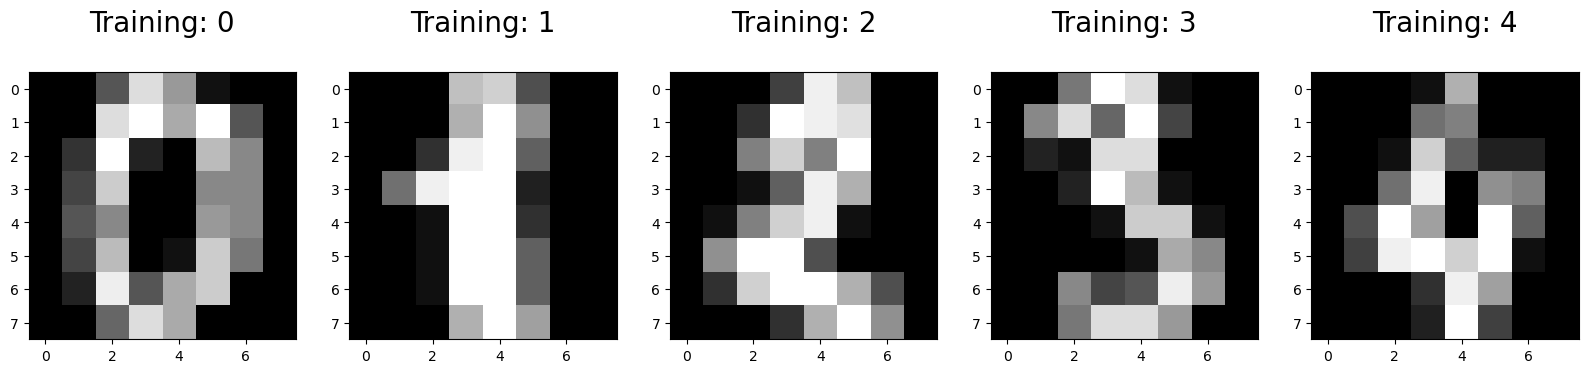

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# show examples of dataset
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

In [6]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25, random_state=8)
print(X_train[256], y_train[256])

[ 0.  0.  2. 16. 10.  0.  0.  0.  0.  0.  4. 16. 16.  5.  0.  0.  0.  0.
  8. 16. 16.  3.  0.  0.  0.  0.  9. 16. 16.  3.  0.  0.  0.  0.  8. 16.
 16.  3.  0.  0.  0.  0.  8. 16. 16.  1.  0.  0.  0.  0.  5. 16. 14.  0.
  0.  0.  0.  0.  1. 12. 16.  3.  0.  0.] 1


In [58]:
# 2 batch gradient descent (GD) for Logistic regression
def LogisticRegression_GD(X_train, y_train, learning_rate):
    #TODO
    C = 10
    n = X_train.shape[0]
    d = X_train.shape[1]
    W = np.zeros((d, C)) # initialization of W and b. Maybe need to change.
    b = np.zeros((1, C))
    Y = np.zeros((n, C))
    Y[np.arange(n), y_train] = 1

    losses = []
    epsilon = 1e-4
    eta = 0.1
    max_epoch = 500

    for i in range(max_epoch):
        z = np.matmul(X_train, W) + b
        z = z - np.reshape(np.max(z, axis = 1), (z.shape[0], -1))
        P = np.exp(z)
        P = P / np.reshape(np.sum(P, axis = 1), (P.shape[0], -1))
        
        loss = -np.sum(np.multiply(np.log(P), Y)) / n \
            + eta / 2 * np.sum(np.multiply(W, W))
        grad_W = np.matmul(X_train.T, P - Y) / n + eta * W
        grad_b = np.matmul(np.ones((1, n)), P - Y) / n + eta * b
        W -= learning_rate * grad_W
        b -= learning_rate * grad_b

        if len(losses) > 0 and abs(loss - losses[-1]) < epsilon:
            break
        losses.append(loss)
    
    return W, b, losses

def prediction(X, W, b):
    z = np.matmul(X, W) + b
    z = z - np.reshape(np.max(z, axis = 1), (z.shape[0], -1))
    P = np.exp(z)
    P = P / np.reshape(np.sum(P, axis = 1), (P.shape[0], -1))
    y_hat = np.argmax(P, axis = 1)
    return y_hat

---------------------------------------
learning rate = 0.05
training precision = 0.9888641425389755
test precision = 0.9711111111111111
---------------------------------------
learning rate = 0.005
training precision = 0.9747587230883444
test precision = 0.9644444444444444
---------------------------------------
learning rate = 0.01
training precision = 0.9769858945805494
test precision = 0.9666666666666667


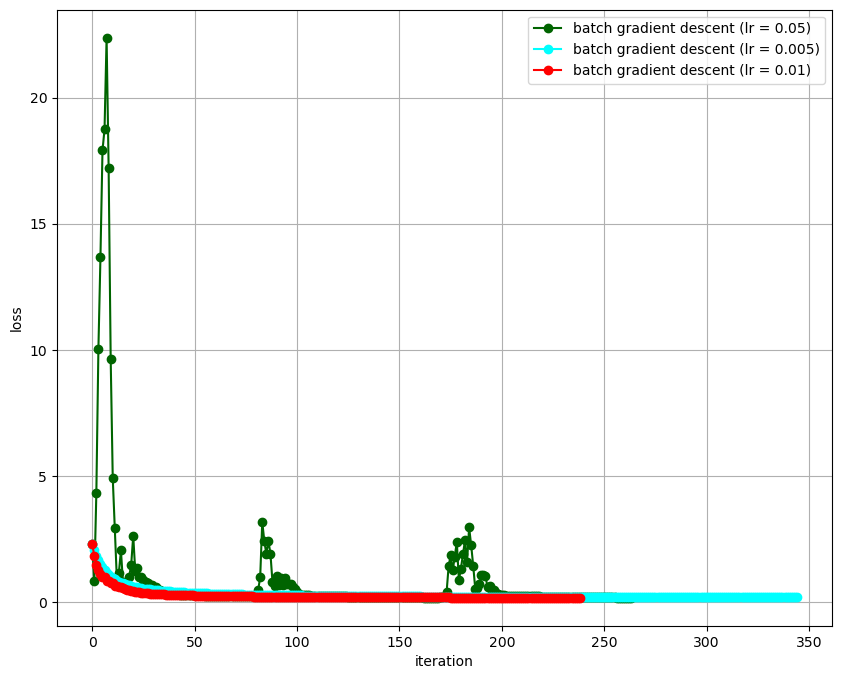

In [68]:
# evaluation of different learning rate
learning_rate = [5.0e-2, 5.0e-3, 1.0e-2]
cl = ['darkgreen', 'cyan', 'red']
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(len(learning_rate)):

    print('---------------------------------------')
    print('learning rate =', learning_rate[i])
    
    W, b, loss_GD = LogisticRegression_GD(X_train, y_train, learning_rate[i])
    
    #TODO
    y_train_hat = prediction(X_train, W, b)
    prec_train = np.sum(y_train_hat == y_train) / y_train_hat.size
    print('training precision =', prec_train)

    #TODO
    y_test_hat = prediction(X_test, W, b)
    prec_test = np.sum(y_test_hat == y_test) / y_test_hat.size
    print('test precision =', prec_test)
    
    plt.plot(loss_GD, c = cl[i], ls = '-', marker = 'o', label = 'batch gradient descent (lr = ' + str(learning_rate[i]) + ')')

plt.grid()
plt.legend()
plt.xlabel('iteration')
plt.ylabel('loss')
plt.savefig('figs/1.2.pdf')

In [109]:
# 4 stochastic gradient descent (SGD) for Logistic regression

def batch_loader(X, y, Y, batch_size, shuffle = False):
    n = X.shape[0]
    if shuffle:
        idx = np.random.shuffle(np.arange(n))
        X, y, Y = X[idx, :].reshape(n, -1), y[idx].reshape(n, -1), Y[idx, :].reshape(n, -1)
        #print(X.shape, y.shape, Y.shape)
    for i in range(0, n, batch_size):
        X_batch = X[i:i + batch_size, :]
        y_batch = y[i:i + batch_size]
        Y_batch = Y[i:i + batch_size, :]
        yield X_batch, y_batch, Y_batch

def CE_loss(X, Y, W, b, eta):
    n = X.shape[0]

    z = np.matmul(X, W) + b
    z = z - np.reshape(np.max(z, axis = 1), (z.shape[0], -1))
    P = np.exp(z)
    P = P / np.reshape(np.sum(P, axis = 1), (P.shape[0], -1))

    loss = -np.sum(np.multiply(np.log(P), Y)) / n \
            + eta / 2 * np.sum(np.multiply(W, W))
    return loss

def gradient(X, Y, W, b, eta):
    n = X.shape[0]

    z = np.matmul(X, W) + b
    z = z - np.reshape(np.max(z, axis = 1), (z.shape[0], -1))
    P = np.exp(z)
    P = P / np.reshape(np.sum(P, axis = 1), (P.shape[0], -1))

    loss = -np.sum(np.multiply(np.log(P), Y)) / n \
            + eta / 2 * np.sum(np.multiply(W, W))
    grad_W = np.matmul(X.T, P - Y) / n + eta * W
    grad_b = np.matmul(np.ones((1, n)), P - Y) / n + eta * b

    return grad_W, grad_b

def LogisticRegression_SGD(X, y, batch_size, lr = 1.0e-2, eta = 2.0e-1, eps = 1.0e-4, alpha = 0.5, max_epoch = 500):
    
    #TODO: initialization
    notstop = True
    epoch = 0
    loss = []    

    n = X.shape[0]
    d = X.shape[1]
    C = 10
    Y = np.zeros((n, C))
    Y[np.arange(n), y] = 1
    
    W = np.zeros((d, C)) 
    b = np.zeros((1, C))

    # optimization loop	
    while notstop and epoch < max_epoch:
        #TODO: SGD of each epoch
        for X_batch, y_batch, Y_batch in batch_loader(X, y, Y, batch_size, shuffle = True):
            grad_W, grad_b = gradient(X_batch, Y_batch, W, b, eta)
            W -= lr * grad_W
            b -= lr * grad_b
        L = CE_loss(X, Y, W, b, eta)
        loss.append(L)
        
        # half lr if not improving in 10 epochs
        if epoch > 10:
            if loss[epoch - 10] <= loss[epoch] - eps:
                lr *= alpha
                print('reduce learning rate to', lr)
        
        # stop if not improving in 20 epochs
        if epoch > 20:
            if loss[epoch - 20] <= loss[epoch] - eps or abs(loss[epoch] - loss[epoch-1]) <= eps:                
                notstop = False
                break
            
        epoch += 1
        
        #TODO: W and b

    return (W, b, loss)

---------------------------------------
batch_size = 10
final value of loss = 0.15986300179672264
training precision = 0.9725315515961396
test precision = 0.9488888888888889
---------------------------------------
batch_size = 50
final value of loss = 0.11953997143962224
training precision = 0.991833704528582
test precision = 0.9733333333333334
---------------------------------------
batch_size = 100
final value of loss = 0.1204504973695697
training precision = 0.9903489235337788
test precision = 0.9733333333333334


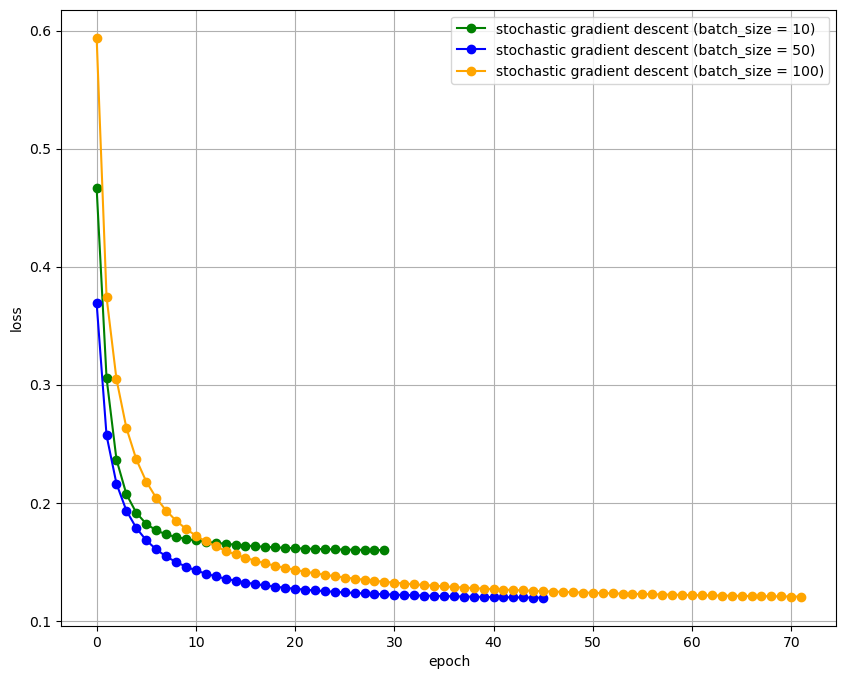

In [128]:
# evaluation of different batch size
bs = [10, 50, 100]
cl = ['green', 'blue', 'orange']
# TODO: different learning rate for different batch size
lr = [0.01, 0.01, 0.01]
fig, ax = plt.subplots(figsize=(10, 8))


for i in range(len(bs)):
    
    print('---------------------------------------')
    print('batch_size =', bs[i])
    W, b, loss_SGD = LogisticRegression_SGD(
        X_train, 
        y_train, 
        bs[i], 
        lr[i], 
        eta = 0.05, 
        eps = 1.0e-4, 
        alpha = 0.5, 
        max_epoch = 500)
    print('final value of loss =', loss_SGD[-1])
    
    #TODO
    y_train_hat = prediction(X_train, W, b)
    prec_train = np.sum(y_train_hat == y_train) / y_train_hat.size
    print('training precision =', prec_train)

    #TODO
    y_test_hat = prediction(X_test, W, b)
    prec_test = np.sum(y_test_hat == y_test) / y_test_hat.size
    print('test precision =', prec_test)
    
    plt.plot(loss_SGD, c = cl[i], ls = '-', marker = 'o', label = 'stochastic gradient descent (batch_size = ' + str(bs[i]) + ')')

plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('figs/1.5.pdf')



---------------------------------------
batch_size = 10
final value of loss = 0.15986300179672264
training precision = 0.9725315515961396
test precision = 0.9488888888888889
---------------------------------------
batch_size = 10
final value of loss = 0.11942549507426536
training precision = 0.991833704528582
test precision = 0.9733333333333334
---------------------------------------
batch_size = 50
final value of loss = 0.11953997143962224
training precision = 0.991833704528582
test precision = 0.9733333333333334
---------------------------------------
batch_size = 50
final value of loss = 0.12598683440789057
training precision = 0.9866369710467706
test precision = 0.9644444444444444
---------------------------------------
batch_size = 100
final value of loss = 0.1204504973695697
training precision = 0.9903489235337788
test precision = 0.9733333333333334
---------------------------------------
batch_size = 100
final value of loss = 0.12272017988278741
training precision = 0.9896065330

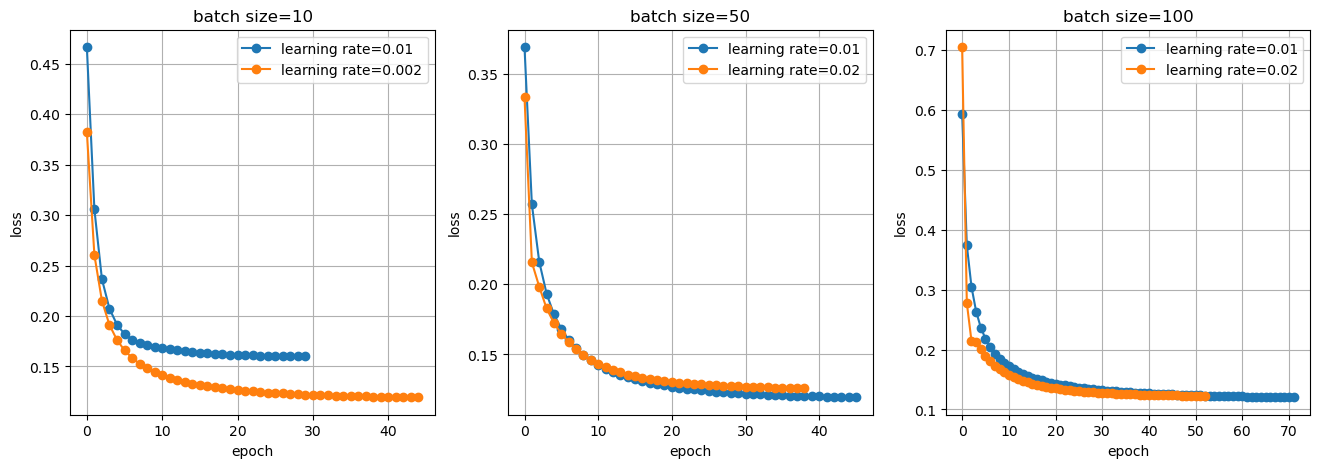

In [143]:
lr = [[0.01, 0.002], [0.01, 0.02], [0.01, 0.02]]
plt.figure(figsize=(16, 5))
for i, bs in enumerate([10, 50, 100]):
    plt.subplot(1, 3, i + 1)
    for l in lr[i]:

        print('---------------------------------------')
        print('batch_size =', bs)
        W, b, loss_SGD = LogisticRegression_SGD(
            X_train, 
            y_train, 
            bs, 
            l, 
            eta = 0.05, 
            eps = 1.0e-4, 
            alpha = 0.5, 
            max_epoch = 500)
        print('final value of loss =', loss_SGD[-1])
        
        #TODO
        y_train_hat = prediction(X_train, W, b)
        prec_train = np.sum(y_train_hat == y_train) / y_train_hat.size
        print('training precision =', prec_train)

        #TODO
        y_test_hat = prediction(X_test, W, b)
        prec_test = np.sum(y_test_hat == y_test) / y_test_hat.size
        print('test precision =', prec_test)
    
        plt.plot(loss_SGD, ls = '-', marker = 'o', label = 'stochastic gradient descent (batch_size = ' + str(bs) + ')')
    plt.grid()
    plt.title('batch size=' + str(bs))
    plt.legend(['learning rate=' + str(l) for l in lr[i]])
    plt.xlabel('epoch')
    plt.ylabel('loss')
plt.savefig('figs/1.6.pdf')